### Importing the libraries

In [1]:
import os
import yaml
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import MCFS

from MCFS.utils import path_length, curvature, remove_pts_repetition
from MCFS.isograph import IsoGraph
from MCFS.MMRTC import augmented_isograph, solve_MMRTC_model_GRB
from MCFS.isolines import LayeredIsoLines
from MCFS.planning import Pathfinder, unified_CFS
from MCFS.solution_refinement import *

### 1. Comparing the 3 selectors on all instances

#### Defining the MCFS function

In [2]:
def MCFS(instance_name:str, R:list, aug=True, ref=True) -> float:

    with open(os.path.join("data", "instances", instance_name+".yaml")) as f:
        dict = yaml.load(f, yaml.Loader)
        delta = int(dict["delta"])
        interval = float(dict["interval"])
        with open(f"data/polygons/{dict['polygon']}", "rb") as f:
            polygon = pickle.load(f)
    
    min_x, min_y, max_x, max_y = polygon.bounds
    num_unique = np.unique(R, axis=0).shape[0]

    layered_isolines = LayeredIsoLines.from_polygon(polygon, interval)
    IG = IsoGraph.build(layered_isolines)
    pf = Pathfinder(IG, interval)
    R = [layered_isolines.at(*index) for index in R]
    if aug:
        IG = augmented_isograph(IG, interval=interval, delta=delta)

    try:
        with open(f"{instance_name}-{len(R)}-{aug}.mmrtc.sol", "rb") as f:
            T = pickle.load(f)
    except:
        T = solve_MMRTC_model_GRB(IG, R)
        with open(f"{instance_name}-{len(R)}-{aug}.mmrtc.sol", "wb") as f:
            pickle.dump(T, f)

    if ref:
        T = solution_refinement(IG, T, R, pf)

    Pi, Ls = [], []
    for i in range(len(R)):
        pi, s_list = unified_CFS(
            G = T[i],
            r = R[i],
            pr_idx = i*10,
            selector_type = "MCS"
        )
        remove_pts_repetition(pi)
        # a workaround to make the path align with the boundary
        pi = np.array(pi) * np.array([1 + 0.12/(max_x-min_x), 1 + 0.12/(max_y-min_y)])
        Pi.append(pi)
        Ls.append(path_length(pi))

    return max(Ls)

comb = {'ref': (False, True), 
        'aug':(True, False), 
        'both':(True, True), 
        'none':(False, False)
        }
   

#### Showing the results

In [3]:
fp = os.path.join("data", f"selectors.csv")
if os.path.isfile(fp):
    df = pd.read_csv(fp)
else:
    df = pd.DataFrame()

    for instance_name in ["I", "C", "A", "P", "S", "double_torus", "office"]:
        with open(os.path.join("data", "instances", instance_name+".yaml")) as f:
            dict = yaml.load(f, yaml.Loader)
            with open(f"data/polygons/{dict['polygon']}", "rb") as f:
                polygon = pickle.load(f)

        layered_isolines = LayeredIsoLines.from_polygon(polygon, dict["interval"])
        IG = IsoGraph.build(layered_isolines)

        # random selector
        pi, _ = unified_CFS(
            G = IG,
            r = layered_isolines.at(0, 0),
            pr_idx = 0,
            selector_type = "random"
        )
        remove_pts_repetition(pi)
        K_rnd = np.mean(np.sqrt(np.clip(curvature(np.array(pi)), 0, 1e9)))

        # CFS selector
        pi, _ = unified_CFS(
            G = IG,
            r = layered_isolines.at(0, 0),
            pr_idx = 0,
            selector_type = "CFS"
        )
        remove_pts_repetition(pi)
        K_cfs = np.mean(np.sqrt(np.clip(curvature(np.array(pi)), 0, 1e9)))

        # MCS selector
        pi, _ = unified_CFS(
            G = IG,
            r = layered_isolines.at(0, 0),
            pr_idx = 0,
            selector_type = "MCS"
        )
        remove_pts_repetition(pi)
        K_mcs = np.mean(np.sqrt(np.clip(curvature(np.array(pi)), 0, 1e9)))

        df = pd.concat([df, pd.DataFrame([{"istc":instance_name, "rnd":K_rnd, "cfs": K_cfs, "mcs":K_mcs}])], ignore_index=True)

    df.to_csv(os.path.join("data", f"selectors.csv"), index=False)


df.head(7)

,istc,rnd,cfs,mcs
0,I,2.747233,1.306163,1.268826
1,C,0.947141,0.746633,0.781867
2,A,1.347529,0.847928,0.874221
3,P,2.127721,1.723652,1.277113
4,S,1.030304,0.887142,0.960141
5,double_torus,1.047135,0.818759,0.968892
6,office,12.984454,11.764069,8.289026


### 2. Comparing MCFS makespan over increasing number of robots

#### Running MCFS for instance *2-torus*

In [4]:
fp = os.path.join("data", f"two_torus_num_robots.csv")

if os.path.isfile(fp):
    df_two_torus = pd.read_csv(fp)
else:
    df_two_torus = pd.DataFrame()
    for R in [
        [[0,1], [0,2]],                                                             # 2
        [[0,1], [0,1], [0,2]],                                                      # 3
        [[0,1], [0,1], [0,2], [0,2]],                                               # 4
        [[0,1], [0,1], [0,2], [0,2], [1,0]],                                        # 5
        [[0,0], [0,0], [0,1], [0,1], [0,2], [0,2]],                                 # 6
        [[0,0], [0,0], [0,1], [0,1], [0,1], [0,2], [0,2]],                          # 7
        [[0,0], [0,0], [0,1], [0,1], [0,1], [0,2], [0,2], [1,0]],                   # 8
        [[0,0], [0,0], [0,1], [0,1], [0,1], [0,2], [0,2], [1,0], [2,0]],            # 9
        [[0,0], [0,0], [0,1], [0,1], [0,1], [0,2], [0,2], [1,0], [2,0], [3,0]],     # 10
    ]:
        for key, val in comb.items():
            aug, ref = val
            makespan = MCFS("double_torus", R=R, aug=aug, ref=ref)
            df_two_torus = pd.concat([df_two_torus,
                pd.DataFrame([{"type":key, "k":len(R), "makespan": makespan, "R":R}])], ignore_index=True)

        df_two_torus.to_csv(fp, index=False)


#### Running MCFS for instance *office*

In [5]:
fp = os.path.join("data", f"office_num_robots.csv")

if os.path.isfile(fp):
    df_office = pd.read_csv(fp)
else:
    df_office = pd.DataFrame()
    for R in [
        [[0,0], [1,0]],                                                             # 2
        [[0,0], [0,1], [0,2]],                                                      # 3
        [[0,0], [1,0], [0,1], [0,2]],                                               # 4
        [[0,0], [1,0], [0,1], [1,1], [0,2]],                                        # 5
        [[0,0], [1,0], [0,1], [1,1], [0,2], [2,2]],                                 # 6
        [[0,0], [1,0], [0,1], [1,1], [2,1], [0,2], [2,2]],                          # 7
        [[0,0], [1,0], [2,0], [0,1], [1,1], [2,1], [0,2], [2,2]],                   # 8
        [[0,0], [1,0], [2,0], [0,1], [1,1], [2,1], [0,2], [1,2], [2,2]],            # 9
        [[0,0], [1,0], [2,0], [0,1], [1,1], [2,1], [0,2], [1,2], [2,2], [3,2]],     # 10
    ]:
        for key, val in comb.items():
            aug, ref = val
            makespan = MCFS("office", R=R, aug=aug, ref=ref)
            df_office = pd.concat([df_office,
                pd.DataFrame([{"type":key, "k":len(R), "makespan": makespan, "R":R}])], ignore_index=True)

        df_office.to_csv(fp, index=False)


#### Drawing the results

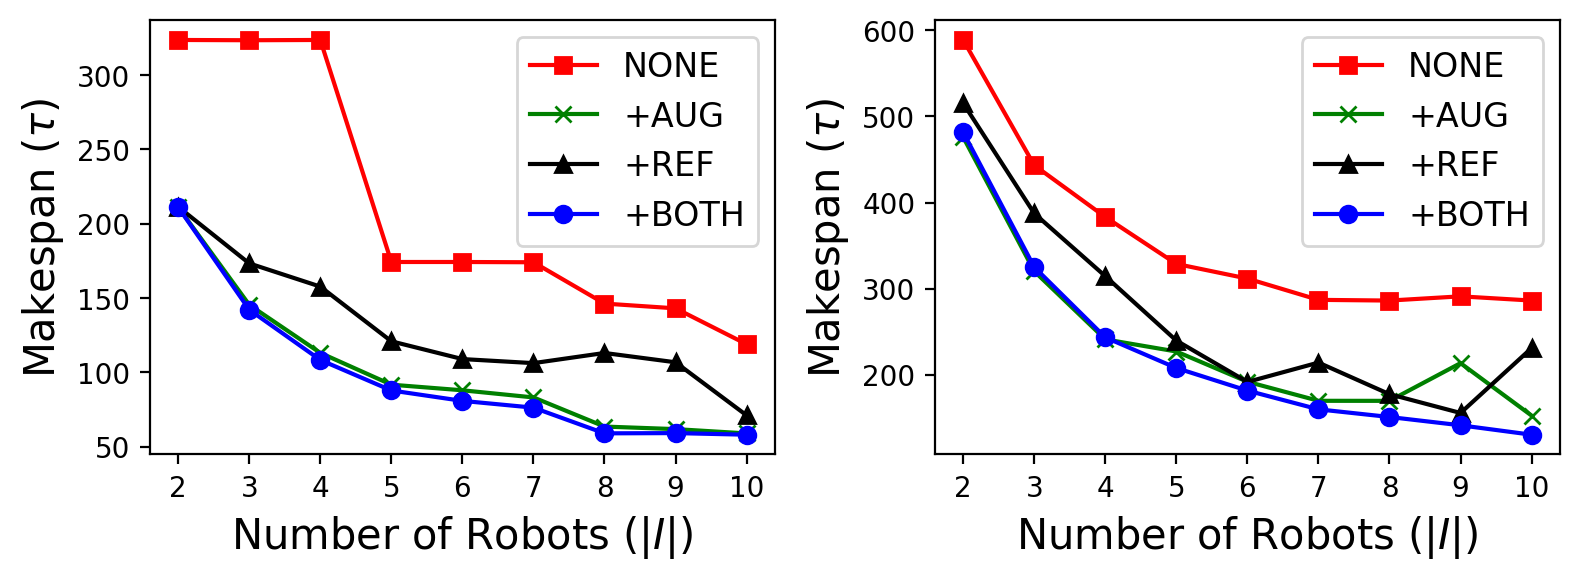

In [6]:
def line(ax, df):
    num_robots = np.arange(2, 11)

    df_none = df[df["type"]=="none"]["makespan"]
    df_aug  = df[df["type"]=="aug"]["makespan"]
    df_ref  = df[df["type"]=="ref"]["makespan"]
    df_both = df[df["type"]=="both"]["makespan"]
    ax.plot(num_robots, df_none, f"-sr", label="NONE")
    ax.plot(num_robots, df_aug, f"-gx", label="+AUG")
    ax.plot(num_robots, df_ref, f"-k^", label="+REF")
    ax.plot(num_robots, df_both, f"-bo", label="+BOTH")

    ax.set_xlabel(r"Number of Robots ($|I|$)", fontsize=15)
    ax.set_ylabel(r"Makespan ($\tau$)", fontsize=15)
    ax.set_xticks(num_robots)
    ax.legend(fontsize=12)

fig, axs = plt.subplots(1, 2, figsize=(8,3), dpi=200)

line(axs[0], df_two_torus)
line(axs[1], df_office)
fig.tight_layout()